# Orbit Analysis

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/russellgoyder/sundial/HEAD?labpath=docs%2Fnb%2Forbit_analysis.ipynb)

The [analemma.orbit][] module calculates Keplerian orbits. In this notebook we will use it to explore the properties of Earth's orbit which, together with its rotation about an axis inclined relative to its orbit, result in [The Equation of Time](equation_of_time.md).

In [1]:
import math
import numpy as np
from numpy import sin, cos
import matplotlib.pyplot as plt
from analemma import orbit, geometry

![Earth's orientation and orbit](https://raw.githubusercontent.com/russellgoyder/sundial-latex/main/figs/MainArena.png "Earth's orientation and orbit.").

In [2]:
earth = orbit.PlanetParameters.earth()

# start time at perihelion, sample once per mean day
t_integers = np.arange(int(earth.N))
t = earth.T_d * t_integers

print(f"t has {len(t)} times from {t[0]} to {t[-1]} seconds")

t has 365 times from 0 to 31449600 seconds


So, the variable $t$ is our timeline, sampling one year at (mean) daily intervals.

The hour angle formula derived in [The Hour Angle](hour_angle.md) has inputs:

* $\sigma(t)$ - the progress of Earth on its orbit
* $\psi(t)$ - the spin of the Earth
* $\alpha$ - the tilt of the Earth's axis

Start by modeling $\sigma(t)$ and $\psi(t)$ linearly to isolate the effect of $\alpha$.

Text(0.5, 1.0, 'Effect of planetary axis tilt ($\\alpha$) on hour angle')

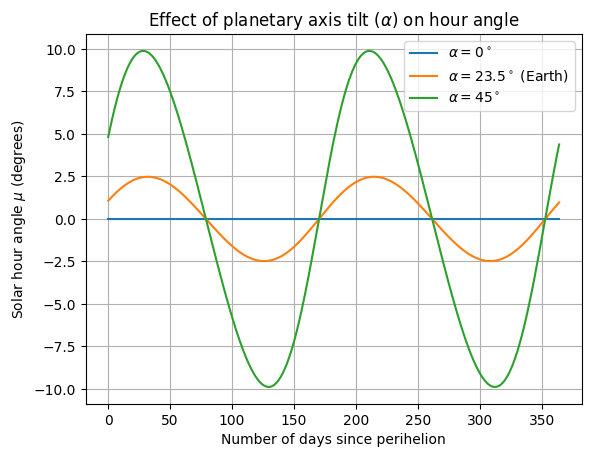

In [3]:
pi = np.pi

# psi increases linearly with time, one complete revolution after one siderial day,
# and an offset of rho
psi = np.mod(earth.rho + earth.om_sd*t, 2*pi)
# Increase sigma at constant rate of 2*pi per solar year to isolate effect of alpha.
# Orbit (phi) starts at perihelion which is earth.rho degrees past -e_1
# and sigma starts at +e_1 which is pi radians away from -e_1, hence pi + earth.rho.
sigma = np.mod(pi + earth.rho + earth.om_y*t, 2*pi)

# calc hour angle
mu = np.mod(geometry.hour_angle(earth.alpha, sigma, psi), 2*pi)
mu0 = np.mod(geometry.hour_angle(0, sigma, psi), 2*pi)
mu45 = np.mod(geometry.hour_angle(45 / 180 * pi, sigma, psi), 2*pi)

def s2d(seconds):
    "Convert seconds to days"
    return seconds / 24 / 3600

def r2d(radians):
    "Convert radians to degrees"
    return radians / pi * 180

fig, ax = plt.subplots()
ax.plot( s2d(t), r2d(pi - mu0), label=r"$\alpha = 0^\circ$" )
ax.plot( s2d(t), r2d(pi - mu), label=r"$\alpha = 23.5^\circ$ (Earth)" )
ax.plot( s2d(t), r2d(pi - mu45), label=r"$\alpha = 45^\circ$" )
ax.legend()
ax.grid()
ax.set_xlabel( "Number of days since perihelion" )
ax.set_ylabel( r"Solar hour angle $\mu$ (degrees)" )
ax.set_title( r"Effect of planetary axis tilt ($\alpha$) on hour angle" )


## Orbital Time

Now to introduce Keplerian dynamics and change the model for $\sigma(t)$. The orbit $(r(t), \phi(t))$ can be parameterized as $r(s)$, $\phi(s)$ and $t(s)$ as derived in the appendix of my paper, just quoted here. Starting with $t(s)$:

Text(0.5, 1.0, 'Orbital Time')

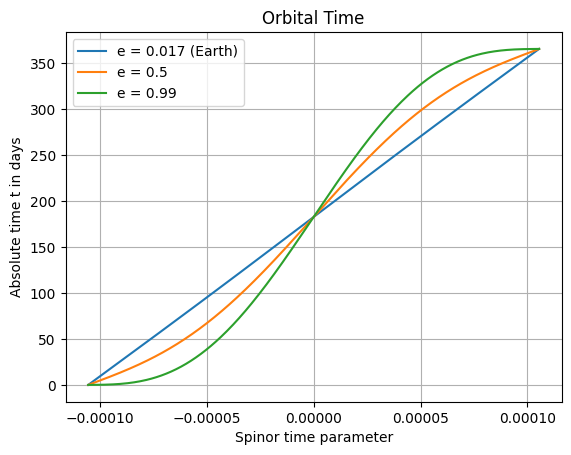

In [4]:
s_vector = np.linspace(-pi/earth.Om/2, pi/earth.Om/2, 365)
t_vector = orbit.orbital_time(s_vector)
t_vector_eccentric = orbit.orbital_time(s_vector, earth.clone_with_eccentricity(0.5))
t_vector_very_eccentric = orbit.orbital_time(s_vector, earth.clone_with_eccentricity(0.99))

fig, ax = plt.subplots()
ax.plot( s_vector, s2d(t_vector), label=f"e = {earth.e} (Earth)" )
ax.plot( s_vector, s2d(t_vector_eccentric), label=f"e = {0.5}" )
ax.plot( s_vector, s2d(t_vector_very_eccentric), label=f"e = {0.99}" )
ax.legend()
ax.grid()
ax.set_xlabel( 'Spinor time parameter' )
ax.set_ylabel( 'Absolute time t in days' )
ax.set_title("Orbital Time")

## Invert the time relation

In order to calcuate $r(t) = r(t(s))$ and $\phi(t) = \phi(t(s))$, we need invert the functional form for $t(s)$.

$s(t)$ is calculated by `orbit.spinor_time()`.

In [5]:
t_eval = 50 * 24*3600 # evaluate 50 days into orbit
s1 = orbit.spinor_time(t_eval)
assert math.isclose(t_eval, orbit.orbital_time(s1), rel_tol=1e-9) # round trip
e99 = 0.99 # very eccentric
s2 = orbit.spinor_time(t_eval, earth.clone_with_eccentricity(e99))
assert not math.isclose(s1, s2, abs_tol=1e-5) # different e means different s
assert math.isclose(t_eval, orbit.orbital_time(s2, earth.clone_with_eccentricity(e99)), rel_tol=1e-7) # round trip

## Orbital Radius

Although not necessary to calculate the equation of time, for completeness let's look at the radial coordinate (from the orbit's focus) over time also:

Text(0.5, 1.0, 'Orbital Radius')

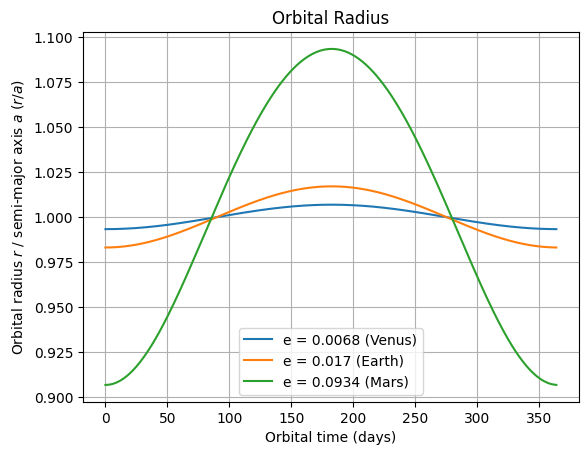

In [6]:
e_venus = 0.0068
e_mars = 0.0934

ven = earth.clone_with_eccentricity(e_venus)
mar = earth.clone_with_eccentricity(e_mars)

t_days = t/3600/24

orb_rad_ratio_venus = orbit.orbital_radius(orbit.spinor_time(t, ven), ven)/earth.a
orb_rad_ratio_earth = orbit.orbital_radius(orbit.spinor_time(t))/earth.a
orb_rad_ratio_mars = orbit.orbital_radius(orbit.spinor_time(t, mar), mar)/earth.a

fig, ax = plt.subplots()
ax.plot( t_days, orb_rad_ratio_venus, label=f"e = {e_venus} (Venus)" )
ax.plot( t_days, orb_rad_ratio_earth, label=f"e = {earth.e} (Earth)" )
ax.plot( t_days, orb_rad_ratio_mars, label=f"e = {e_mars} (Mars)" )
ax.legend()
ax.grid()
ax.set_xlabel("Orbital time (days)")
ax.set_ylabel("Orbital radius $r$ / semi-major axis $a$ ($r/a$)")
ax.set_title("Orbital Radius")

## Orbital Angle

The angle of the orbit (again in radial coordinates with origin at the orbit's focus) varies non-linearly with time for an elliptical orbit, and this provides the second component of the Equation of Time.

Text(0.5, 1.0, 'Orbital Angle')

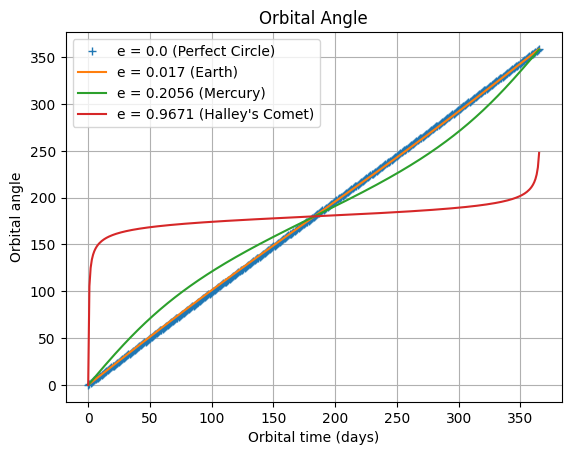

In [7]:
e_circle = 0.0
e_mercury = 0.2056
e_halleys_comet = 0.9671

circ = earth.clone_with_eccentricity(e_circle)
merc = earth.clone_with_eccentricity(e_mercury)
hall = earth.clone_with_eccentricity(e_halleys_comet)

t_days = t_vector/3600/24
orb_angle_circle = orbit.orbital_angle(orbit.spinor_time(t, circ), circ)
orb_angle_earth = orbit.orbital_angle(orbit.spinor_time(t))
orb_angle_mercury = orbit.orbital_angle(orbit.spinor_time(t, merc), merc)
orb_angle_halleys_comet = orbit.orbital_angle(orbit.spinor_time(t, hall), hall)

fig, ax = plt.subplots()
ax.plot( t_days, r2d(orb_angle_circle), "+", label=f"e = {e_circle} (Perfect Circle)" )
ax.plot( t_days, r2d(orb_angle_earth), label=f"e = {earth.e} (Earth)" )
ax.plot( t_days, r2d(orb_angle_mercury), label=f"e = {e_mercury} (Mercury)" )
ax.plot( t_days, r2d(orb_angle_halleys_comet), label=f"e = {e_halleys_comet} (Halley's Comet)" )
ax.legend()
ax.grid()
ax.set_xlabel("Orbital time (days)")
ax.set_ylabel("Orbital angle")
ax.set_title("Orbital Angle")

## Orbital Path

Again, not necessary for the Equation of Time, but for completeness, let's look at the Earth's orbital path:

Text(0.5, 1.0, 'Orbital Path (distance in units of semi-major axis, $a$)')

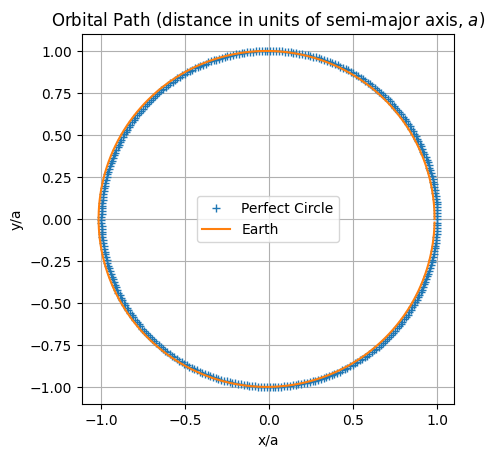

In [8]:
def orbit_path(s, planet = earth):
    return (orbit.orbital_radius(orbit.spinor_time(t, planet), planet)*cos(orbit.orbital_angle(orbit.spinor_time(t, planet), planet)) / planet.a,
            orbit.orbital_radius(orbit.spinor_time(t, planet), planet)*sin(orbit.orbital_angle(orbit.spinor_time(t, planet), planet)) / planet.a) 

path_earth = orbit_path(orbit.spinor_time(t))
circ = earth.clone_with_eccentricity(e_circle)
path_circle = orbit_path(orbit.spinor_time(t, circ), circ)

fig, ax = plt.subplots()
ax.plot(*path_circle, "+", label="Perfect Circle")
ax.plot(*path_earth, label="Earth")
ax.grid()
ax.set_aspect("equal", "box")
ax.legend()
ax.set_xlabel("x/a")
ax.set_ylabel("y/a")
ax.set_title("Orbital Path (distance in units of semi-major axis, $a$)")

## Effect of Orbital Eccentricity

We can isolate the effect of a Keplerian orbit by setting the Earth's axis tilt angle $\alpha$ to zero:

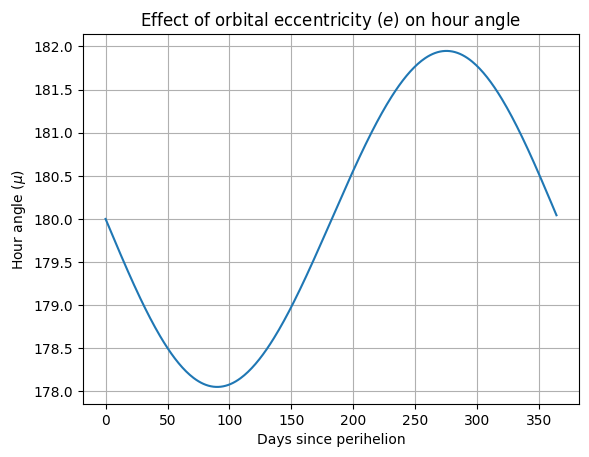

In [9]:
# now account for orbit in rate of increase of sigma
sigma = np.mod(pi + earth.rho + orbit.orbital_angle(orbit.spinor_time(t)), 2*pi)

mu = np.mod(geometry.hour_angle(0.0, sigma, psi), 2*pi)

fig, ax = plt.subplots()
ax.plot(s2d(t), r2d(mu))
ax.grid()
ax.set_xlabel("Days since perihelion")
ax.set_ylabel(r"Hour angle ($\mu$)")
_ = ax.set_title("Effect of orbital eccentricity ($e$) on hour angle")

For the mathematics of the analemma, see the notebooks starting with [Setup and Definitions](sundial_setup.md) and culminating in [The Analemma](analemma.md).